In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Dataset path
DATASET_DIR = 'garbage-dataset'

# Class names (order must match the folder names)
class_names = sorted(os.listdir(DATASET_DIR))
num_classes = len(class_names)
print("Category：", class_names)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Category： ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Num GPUs Available: 1


In [3]:
# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=[0.85, 1.15],
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='reflect'
)

# Training set
train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation set
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Build CNN model
model = Sequential([
    Input(shape=(160, 160, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary()

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_custom_cnn.keras', save_best_only=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint,lr_reduce]
)

# Evaluate the model
loss, acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {acc:.2f}')

# Save the final model
model.save('custom_cnn_final.keras')
print("Model has been saved as custom_cnn_final.keras")

Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


2025-06-29 20:08:31.812397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 20:08:31.812478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 20:08:31.812504: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 20:08:31.967544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 20:08:31.967606: I external/local_xla/xla/stream_executor

Epoch 1/100


I0000 00:00:1751224117.330820  166122 service.cc:145] XLA service 0x7e706401e920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751224117.330899  166122 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2025-06-29 20:08:37.436983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-29 20:08:37.938089: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-06-29 20:08:46.540243: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[32,32,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,160,160]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id"

  2/495 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.0781 - loss: 2.5364   

I0000 00:00:1751224138.667669  166122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/495 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - accuracy: 0.2874 - loss: 2.0609

2025-06-29 20:09:45.096715: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[5,32,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,160,160]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-06-29 20:09:49.991951: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.895311824s
Trying algorithm eng4{k11=1} for conv (f32[5,32,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,160,160]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3423 - loss: 1.9241

/home/eric-u/miniconda3/envs/tf216/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.90743, saving model to best_custom_cnn.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 159s 271ms/step - accuracy: 0.3424 - loss: 1.9238 - val_accuracy: 0.3821 - val_loss: 1.9074 - learning_rate: 1.0000e-04
Epoch 2/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4692 - loss: 1.5606
Epoch 2: val_loss improved from 1.90743 to 1.46292, saving model to best_custom_cnn.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 114s 230ms/step - accuracy: 0.4692 - loss: 1.5606 - val_accuracy: 0.5222 - val_loss: 1.4629 - learning_rate: 1.0000e-04
Epoch 3/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5001 - loss: 1.4581
Epoch 3: val_loss improved from 1.46292 to 1.38626, saving model to best_custom_cnn.keras
495/495 ━━━━━━━━━━━━━━━━━━━━ 112s 225ms/step - accuracy: 0.5001 - loss: 1.4581 - val_accuracy: 0.5396 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 4/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5275 - loss: 1.3976
Epoch 4: val_loss i

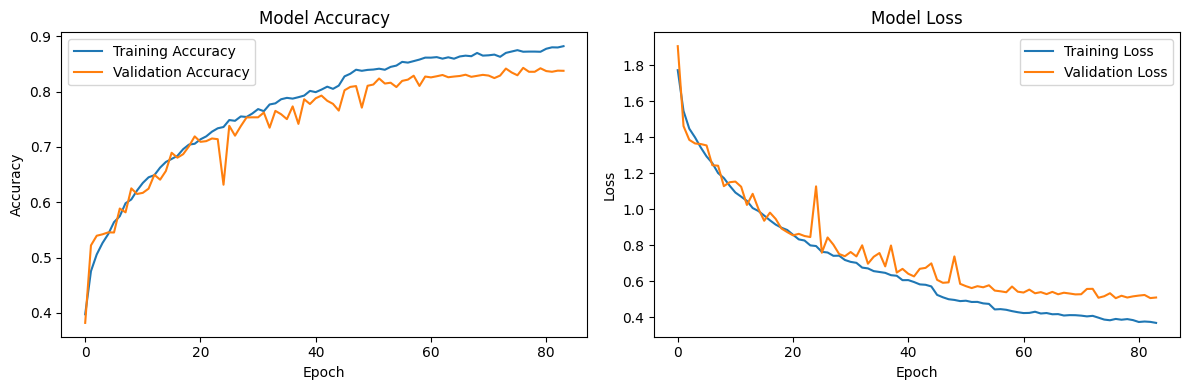

Final training accuracy: 0.8822
Final validation accuracy: 0.8377


In [4]:
import matplotlib.pyplot as plt

# Mapping training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print the final result
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")